In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
# plt.switch_backend('Agg')
plt.rcParams['image.cmap'] = 'gray' 
import numpy as np
import os
from glob import glob
#import nrrd
import numpy as np
import SimpleITK as sitk
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from ipywidgets import interact, interactive
from ipywidgets import widgets
import scipy
from scipy.ndimage.interpolation import zoom
import math
from skimage import filters
from skimage import exposure
from skimage.morphology import binary_opening
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    slicer = False
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            slicer = True
    elif nda.ndim == 4:
        c = nda.shape[-1]
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
        # take a z-slice
        slicer = True
    if (slicer):
        ysize = nda.shape[1]
        xsize = nda.shape[2]
    else:
        ysize = nda.shape[0]
        xsize = nda.shape[1]
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    def callback(z=None):
        extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
        fig = plt.figure(figsize=figsize, dpi=dpi)
        # Make the axis the right size...
        ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
        plt.set_cmap("gray")
        if z is None:
            ax.imshow(nda,extent=extent,interpolation=None)
        else:
            ax.imshow(nda[z,...],extent=extent,interpolation=None)
        if title:
            plt.title(title)
        plt.show()
    if slicer:
        interact(callback, z=(0,nda.shape[0]-1))
    else:
        callback()
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    img_slices = []
    d = 0
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TODO check in code to get Tile Filter working with VectorImages
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
    myshow(img, title, margin, dpi)

In [2]:
def npresample(imgs, spacing, new_spacing, order=2): # new_spacing with z y x consist with imgs
    assert len(imgs.shape) == 3
#     print(spacing, new_spacing, imgs.shape, type(spacing[0]), type(new_spacing[0]))
    new_shape = np.round(imgs.shape * spacing / new_spacing)
#     print(new_shape)
    true_spacing = spacing * imgs.shape / new_shape
    resize_factor = spacing / new_spacing
#     print(resize_factor)
    imgs = zoom(imgs, resize_factor, mode = 'nearest',order=order)
#     print(imgs.shape)
    return np.array(imgs), true_spacing
def getminmaxannotation(segpth, spacing, newspacing=None):
    minxlst, minylst, minzlst, maxxlst, maxylst, maxzlst = [], [], [], [], [], []
    for gtfnm in ['BrainStem', 'Chiasm', 'Mandible', 'OpticNerve_L', 'OpticNerve_R', 'Parotid_L', \
                      'Parotid_R', 'Submandibular_L', 'Submandibular_R']:
        if not os.path.exists(segpth+gtfnm+'.nrrd'): 
            print('miss ', fnm, gtfnm)
            continue
        sitkimggt = sitk.ReadImage(segpth+gtfnm+'.nrrd')
        data = sitk.GetArrayFromImage(sitkimggt)
#         spacing = sitkimggt.GetSpacing()
        zflg, xflg, yflg = True, True, True
        minxlst.append(0)
        minylst.append(0)
        minzlst.append(0)
        maxxlst.append(data.shape[1])
        maxylst.append(data.shape[2])
        maxzlst.append(data.shape[0])
        for zidx in range(data.shape[0]):
            if zflg and data[zidx, :, :].sum() != 0:
                minzlst[-1] = zidx
                zflg = False
            elif zflg is False and data[zidx, :, :].sum() == 0:
                maxzlst[-1] = zidx
                break
        for yidx in range(data.shape[1]):
            if yflg and data[minzlst[-1]:maxzlst[-1], yidx, :].sum() != 0:
                minylst[-1] = yidx
                yflg = False
            elif yflg is False and data[minzlst[-1]:maxzlst[-1], yidx, :].sum() == 0:
                maxylst[-1] = yidx
                break
        for xidx in range(data.shape[2]):
            if xflg and data[minzlst[-1]:maxzlst[-1], minylst[-1]:maxylst[-1], xidx].sum() != 0:
                minxlst[-1] = xidx
                xflg = False
            elif xflg is False and data[minzlst[-1]:maxzlst[-1], minylst[-1]:maxylst[-1], xidx].sum() == 0:
                maxxlst[-1] = xidx
                break
        if newspacing is not None:
            minxlst[-1] = int(round(minxlst[-1]*1.0 * spacing[0] / newspacing[0]))
            maxxlst[-1] = int(round(maxxlst[-1]*1.0 * spacing[0] / newspacing[0]))+1
            minylst[-1] = int(round(minylst[-1]*1.0 * spacing[1] / newspacing[1]))
            maxylst[-1] = int(round(maxylst[-1]*1.0 * spacing[1] / newspacing[1]))+1
            minzlst[-1] = int(round(minzlst[-1]*1.0 * spacing[2] / newspacing[2]))
            maxzlst[-1] = int(round(maxzlst[-1]*1.0 * spacing[2] / newspacing[2]))+1
        print(gtfnm, minzlst[-1], maxzlst[-1], minylst[-1], maxylst[-1], minxlst[-1], maxxlst[-1])
    print('minz %d, maxz %d, miny %d, maxy %d, minx %d, maxx %d', min(minzlst), max(maxzlst), min(minylst), \
          max(maxylst), min(minxlst), max(maxxlst))
    return min(minzlst), max(maxzlst), min(minylst), max(maxylst), min(minxlst), max(maxxlst)
def imhist3d(im, nbin=1024):
    # calculates normalized histogram of an image
    m, n, z = im.shape
    h = [0.0] * (nbin + 1)
    for i in range(m):
        for j in range(n):
            for k in range(z):
                if im[i, j, k] != 0:
                    h[int(round(im[i, j, k]*nbin))]+=1
    return np.array(h)/(sum(h))
def cumsum(h):
    # finds cumulative sum of a numpy array, list
    return [sum(h[:i+1]) for i in range(len(h))]
def histeq(im, nbin=1024):
    #calculate Histogram
    h = imhist3d(im, nbin=nbin)
    cdf = np.array(cumsum(h)) #cumulative distribution function
    sk = np.array(cdf) #finding transfer function values
    s1, s2, s3 = im.shape
    Y = np.zeros_like(im)
    # applying transfered values for each pixels
    for i in range(s1):
        for j in range(s2):
            for k in range(s3):
                if im[i,j,k] == 0:
                    Y[i,j,k] = 0
                else:
                    Y[i, j, k] = sk[int(round(im[i, j, k]*nbin))]
    H = imhist3d(Y)
    #return transformed image, original and new istogram, 
    # and transform function
    return Y , h, H, sk, cumsum(imhist3d(Y, nbin=nbin))
path = '/home/bharat/Desktop/FYP/structures_extraction/hospital-data/'
pidlst = [pid for pid in os.listdir(path)]
minxspace, minyspace, minzspace = 0.7599999904632568, 0.7599999904632568, 1.249632716178894
structurefnmlst = ('BrainStem', 'Chiasm', 'Mandible', 'OpticNerve_L', 'OpticNerve_R', 'Parotid_L', 'Parotid_R', \
                   'Submandibular_L', 'Submandibular_R')

In [3]:
pidlst

['18RT0455',
 '19RT0893',
 '19RT0318',
 '19RT0927',
 '18RT0373',
 '19RT0648',
 '19RT0678',
 '18RT0207']

processing %s 18RT0207


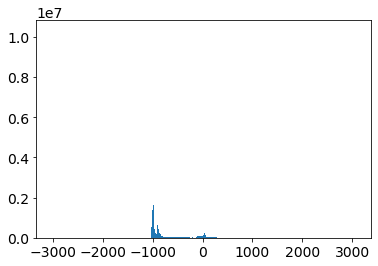

BrainStem 103 122 174 207 242 282
miss  18RT0207 Chiasm
Mandible 77 91 92 168 216 307
miss  18RT0207 OpticNerve_L
miss  18RT0207 OpticNerve_R
Parotid_L 94 109 154 195 301 323
Parotid_R 92 111 158 194 198 228
miss  18RT0207 Submandibular_L
miss  18RT0207 Submandibular_R
minz %d, maxz %d, miny %d, maxy %d, minx %d, maxx %d 77 122 92 207 198 323


In [39]:
idx = 0
fnm = pidlst[idx]
print('processing %s', fnm)
#assert not fnm.startswith('HN-HMR')
sitkimg = sitk.ReadImage(path+fnm+'/image.nrrd')
nparr = sitk.GetArrayFromImage(sitkimg)
plt.hist(nparr.reshape((-1)), bins=1000)
plt.show()
minv = -1024.0
maxv = nparr.max()
#maxv = min(-256, nparr.max())
nparr[nparr < minv] = minv
#maxv = min(-256, nparr.max())
#nparr[nparr > maxv] = maxv
nparr = (nparr - minv)*1.0 / (1.0*(maxv - minv))
minz0, maxz0, miny0, maxy0, minx0, maxx0 = getminmaxannotation(path+fnm+'/structures/', \
                                                               np.array([minxspace, minyspace, minzspace]), \
                                                               np.array([minxspace, minyspace, minzspace]))

In [40]:
minz, maxz, miny, maxy, minx, maxx = 50, 140, 70, 230, 170, 340
assert minz < minz0 and maxz > maxz0 and miny < miny0 and maxy > maxy0 and minx < minx0 and maxx > maxx0
nparrplt = np.array(nparr)
nparrplt[:, maxy, :] = 1
nparrplt[:, miny, :] = 1
nparrplt[:, :, maxx] = 1
nparrplt[:, :, minx] = 1
myshow3d(sitk.GetImageFromArray(nparrplt))

interactive(children=(IntSlider(value=83, description='z', max=166), Output()), _dom_classes=('widget-interact…

In [41]:
nparr = np.array(nparr[minz:maxz, miny:maxy, minx:maxx])

In [42]:
myshow3d(sitk.GetImageFromArray(nparr))
# minv = nparr.min()
# maxv = nparr.max()
# nparr = (nparr - minv)*1.0 / (1.0*(maxv-minv))
# myshow3d(sitk.GetImageFromArray(nparr))
for sfnm in os.listdir(path+fnm+'/structures/'):
    snparr = sitk.GetArrayFromImage(sitk.ReadImage(path+fnm+'/structures/'+sfnm))
    assert snparr.min() == 0 and snparr.max() == 1
    snparr = np.array(snparr[minz:maxz, miny:maxy, minx:maxx])
    print(sfnm)
    s_nparr = np.array(nparr)
    s_nparr[snparr != 0] -= 0.2
    fig = plt.figure()
    myshow3d(sitk.GetImageFromArray(s_nparr))

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Oesophagus.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

PCM.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Inner Ear Right.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

patient.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

BrainStem.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

SOFT PALATE.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Larynx.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Inner ear Left.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Spinacord.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Parotid_L.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

SX BED.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

LIPS.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Parotid_R.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

Mandible.nrrd


<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=44, description='z', max=89), Output()), _dom_classes=('widget-interact'…

In [43]:
np.save(path+fnm+'/img_crp.npy', nparr)
for sfnm in os.listdir(path+fnm+'/structures/'):
    snparr = sitk.GetArrayFromImage(sitk.ReadImage(path+fnm+'/structures/'+sfnm))
    assert snparr.min() == 0 and snparr.max() == 1
    snparr = np.array(snparr[minz:maxz, miny:maxy, minx:maxx])
    np.save(path+fnm+'/structures/'+sfnm[:-len('.nrrd')]+'_crp.npy', snparr)